## Constructing the Dataset 
#### Reading the data from two different JSON files and combing the required metatadata with the reviews and score data

In [ ]:
import threading 
import time 
import pandas as pd 

#Function that parses reviews data from json file
def _extract_reviews(path_name,reviews,reviews_lock,products,products_lock,queued,queued_lock,merged_data,merged_data_lock):
    
    with open(path_name, 'r') as file:
        
        previous_asin = 'alpha'
        
        for line in file:
            if len(merged_data) <  1048576: #650000
                #Evaluating an observation that is in json would convert it to a dictionary in python
                review_dict = eval(line)
                #Extracting the unique identifier for each movie/tv shows title
                asin = review_dict.get('asin')
                
                #if asin is missing for a title , dump that data and keep parsing 
                if asin == None:
                    del line 
                    del review_dict
                    del asin 
                    continue 
                #if the asin for the observation already exists as a key in the reviews dictionary
                #simply append the dictionary for that observation in the list associated with the asin key
                if asin in reviews:
                    with reviews_lock:
                        reviews[asin].append( review_dict )
                #if asin doesn't exist as a key, make a new one and associate a list to it with the observation dict        
                else:
                    with reviews_lock:
                        reviews[asin] = [ review_dict ] 
                        
                #This means we've moved on to the reviews for the next product due to how all the
                #reviews are structured in the json file
                if previous_asin != asin:
                    #Check if product thread has found the metada for that title while parsing the product data file
                    if previous_asin in products:
                        
                        product_metadata = products.get( previous_asin )
                        
                        with products_lock:
                            del products[previous_asin]
                        
                        for review in reviews[previous_asin]:
                            full_review_dict = _build_full_review_dict( review, product_metadata )
                            with merged_data_lock:
                                merged_data.append( full_review_dict )
                            del review
                            del full_review_dict
                            
                        with reviews_lock:
                            del reviews[previous_asin]
                        
                        del product_metadata
                    #If not then simply add that product asin to the queued dictionary to be parsed when product asin is found     
                    else:
                        
                        with queued_lock:
                            queued.add( previous_asin )
                            
                            
                previous_asin = asin
                #clean up memory
                del line 
                del review_dict
                
            else:
                break 
                        
                
#Function that parses products metadata from json file
def _extract_product_meta(path_name,reviews,reviews_lock,products,products_lock,queued,queued_lock,merged_data,merged_data_lock):
    
    with open(path_name, 'r') as file:
        
        for line in file:
            #Limiting total data to 650,000 observations 
            if len(merged_data) < 1048576: #650000
                product_dict = eval(line)
                
                asin = product_dict.get('asin')
                if asin == None or product_dict.get('title') == None:
                    del line 
                    del product_dict
                    del asin 
                    continue 
                    
                categories = product_dict.get('categories')
                #Checking product categories exist and are 'movies' or 'tv' or 'movies & tv'
                if categories != None:
                    
                    sanitized_categories = [ c.lower() for c in categories[0] ]
                    
                    if 'movies' not in sanitized_categories and \
                    'tv' not in sanitized_categories and \
                    'movies & tv' not in sanitized_categories:
                        del line 
                        del product_dict
                        del asin 
                        del categories 
                        del sanitized_categories
                        continue 
                    else:
                        del categories 
                        del sanitized_categories 
                #If the reviews for the product have already been parsed awaiting metada , extract and build a full observation 
                #with product reviews and title 
                if asin in queued:
                    with queued_lock:
                        queued.remove(asin)
                        
                    for review in reviews[asin]:
                        full_review_dict = _build_full_review_dict( review, product_dict )
                        
                        with merged_data_lock:
                            merged_data.append(full_review_dict)
                            
                        del review 
                        del full_review_dict
                            
                    with reviews_lock:
                        del reviews[asin]
                        
                #If the reviews for this product have not been parsed , put the unique identifier for this product in
                #the product dictionary which will be extracted when they are parsed by the review thread 
                else:
                    with products_lock:
                        products[asin] = { 'title': product_dict.get('title') }
                        
                #clean up memory        
                del line 
                del product_dict
                del asin 
                
            else:
                break
                
#Given the observations as two deparate dicitonaries, combines them into one using relevant information                 
def _build_full_review_dict( review_dict, product_meta_dict ):
    full = {}
    full['reviewerID'] = review_dict.get('reviewerID')
    full['asin'] = review_dict.get('asin')
    full['reviewerName'] = review_dict.get('reviewerName')
    full['helpful'] = review_dict.get('helpful')
    full['reviewText'] = review_dict.get('reviewText')
    full['overall'] = review_dict.get('overall')
    full['summary'] = review_dict.get('summary')
    full['title'] = product_meta_dict.get('title')
    return full 


reviews = {}
reviews_lock = threading.Lock()

products = {}
products_lock = threading.Lock()

queued = set()
queued_lock = threading.Lock()

merged_data = []
merged_data_lock = threading.Lock()

#Initialize thread that will parse reviews 
reviews_thread = threading.Thread( target = _extract_reviews , 
                                 args = ( 'reviews_Movies_and_TV.json', 
                                        reviews,reviews_lock,products,products_lock,queued,queued_lock,merged_data,merged_data_lock) 
                                 )
#Initialize thread that will parse products 
products_thread = threading.Thread( target = _extract_product_meta , 
                                 args = ( 'meta_Movies_and_TV.json', 
                                        reviews,reviews_lock,products,products_lock,queued,queued_lock,merged_data,merged_data_lock) 
                                 )

#Start timer 
start = time.time()
#Start threads
reviews_thread.start()
products_thread.start()
#Momentarily print progress report to the console 
counter = 0
while reviews_thread.isAlive() or products_thread.isAlive():
    if counter % 3000000 == 0:
        print ('Reviews left in reviews dict: ' + str(len(reviews)) + ', Products sitting in products dict: ' + str(len(products)) + ', Total data merged: ' + str(len(merged_data)))
        counter += 1
        pass
    else:
        counter += 1
        pass
    
#Calculate time threads are done running 
end = time.time()
#Print final report including total time elapsed 
print('Reviews remaining in reviews dict: ' + str(len(reviews)))
print('Irrelevant products sitting in products dict: ' + str(len(products)))
print('Total relevant reviews merged with the products metadata: ' + str(len(merged_data)))
print('\nExample of a full observation: ' + str(merged_data[0]) + '\n')


time_elapsed = end - start

print('Total time elapsed: ' + str(time_elapsed) + ' seconds')

Reviews left in reviews dict: 5, Products sitting in products dict: 0, Total data merged: 0
Reviews left in reviews dict: 184, Products sitting in products dict: 92854, Total data merged: 351406
Reviews left in reviews dict: 857, Products sitting in products dict: 78151, Total data merged: 781434
Reviews remaining in reviews dict: 1638
Irrelevant products sitting in products dict: 68830
Total relevant reviews merged with the products metadata: 1048590

Example of a full observation: {'reviewerID': 'AH3QC2PC1VTGP', 'asin': '0000143561', 'reviewerName': 'Great Home Cook', 'helpful': [2, 4], 'reviewText': "I have to admit that I am a fan of Giada's cooking and I had great expectations when I ordered this set. They were however, crushed. While I still love Giada's cooking, this set is just a way for Food Network to make money. They really cheated with these DVD's. All they have are the video from the show, no text recipes, no link to the on line shows and no computer support. They play in 

In [ ]:
#Clean up
del reviews, products, queued
#Convert to pandas df
data = pd.DataFrame(merged_data)
#Save data to csv file on hard disk 
data.to_csv('amazon_movies_and_tv_reviewsM.csv')
#Clean up
del merged_data

In [ ]:
#Loading the data from the csv file to avoid having to parse it from JSON again and again
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
data = pd.read_csv('amazon_movies_and_tv_reviewsM.csv')

In [ ]:
#Dropping columsn with any null values
data = data.dropna()\
.drop('Unnamed: 0',axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046027 entries, 0 to 1048589
Data columns (total 8 columns):
reviewerID      1046027 non-null object
asin            1046027 non-null object
reviewerName    1046027 non-null object
helpful         1046027 non-null object
reviewText      1046027 non-null object
overall         1046027 non-null float64
summary         1046027 non-null object
title           1046027 non-null object
dtypes: float64(1), object(7)
memory usage: 71.8+ MB


In [ ]:
data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,title
0,AH3QC2PC1VTGP,0000143561,Great Home Cook,"[2, 4]",I have to admit that I am a fan of Giada's coo...,2.0,Don't waste your money,"Everyday Italian (with Giada de Laurentiis), V..."
1,A1CV1WROP5KTTW,0000589012,"Alberta M. Worth ""BertieMWorth""","[2, 2]",I have read many books and literature written ...,5.0,"""Why Don't They Just Qiut"" DVD Roundtable Disc...",Why Don't They Just Quit? DVD Roundtable Discu...
2,AP57WZ2X4G0AA,0000589012,Amy Arnett-German,"[0, 1]","The information is good, but the presentation ...",2.0,Boring,Why Don't They Just Quit? DVD Roundtable Discu...
3,A3NMBJ2LCRCATT,0000589012,Carole J. Hopkins,"[1, 1]",I have read the original Why Don't They Just Q...,5.0,Very helpful,Why Don't They Just Quit? DVD Roundtable Discu...
4,A5Y15SAOMX6XA,0000589012,Catherine E. Wetzler,"[12, 16]","I, too, purchased this to use with my patients...",2.0,C+ At Best,Why Don't They Just Quit? DVD Roundtable Discu...


In [ ]:
#Combining review text and summary columns into one column called 'review_text
data['review_text'] = data['reviewText'] + ' . ' + data['summary']
del data['reviewText']
del data['summary']
data.head()

,reviewerID,asin,reviewerName,helpful,overall,title,review_text
0,AH3QC2PC1VTGP,0000143561,Great Home Cook,"[2, 4]",2.0,"Everyday Italian (with Giada de Laurentiis), V...",I have to admit that I am a fan of Giada's coo...
1,A1CV1WROP5KTTW,0000589012,"Alberta M. Worth ""BertieMWorth""","[2, 2]",5.0,Why Don't They Just Quit? DVD Roundtable Discu...,I have read many books and literature written ...
2,AP57WZ2X4G0AA,0000589012,Amy Arnett-German,"[0, 1]",2.0,Why Don't They Just Quit? DVD Roundtable Discu...,"The information is good, but the presentation ..."
3,A3NMBJ2LCRCATT,0000589012,Carole J. Hopkins,"[1, 1]",5.0,Why Don't They Just Quit? DVD Roundtable Discu...,I have read the original Why Don't They Just Q...
4,A5Y15SAOMX6XA,0000589012,Catherine E. Wetzler,"[12, 16]",2.0,Why Don't They Just Quit? DVD Roundtable Discu...,"I, too, purchased this to use with my patients..."


## Preprocessing Text Data 
#### Preprocessing methods applied to text reviews before any kind of modelling. 

<br>

*   Lower Case -> lower case everything for consistency
*   Expand Contractions -> 'don't' becomes 'do not', 'y'all' becomes 'you all' ...etc
*   Split Alphanum -> Eg: '1little piggy' becomes '1 little piggy'
*   Strip Multiple White Spaces -> 'too\s\s\sfar' becomes 'too\sfar'
*   Strip Non Alphanum -> Get rid of special characters like '$','@' ...etc 
*   Strip Numeric -> Remove numerical characters. This is applied after separating alphanums so we can salvage the non numeric components without having to throw the entire word away
*   Strip Punctuation -> 'Bond, James Bond' becomes 'Bond James Bond'
*   Strip Tags -> Strip away and lingering HTML Tags in our data

<br>

Notice I'm not using popular text normalizing methods such as stemming or lemmatizing since they are not usually used in conjuction with deep learning methods which is our goal here.

In [ ]:
import numpy as np
import re
import time
from gensim.parsing.preprocessing import preprocess_string, split_alphanum,\
strip_multiple_whitespaces, strip_non_alphanum, strip_numeric, \
strip_punctuation, strip_tags
import pkg_resources
import multiprocessing
from multiprocessing import Pool, Lock
#Lower case the given observation
def lower_case(string):
    return string.lower()
#Function that parses the text file with contractions and creates a dictionary from it
def create_contraction_dict(contractions_file):
    contraction_dict = {}
    with open(contractions_file) as file:
        for line in file:
            mapping = line.strip().split(':')
            contraction_dict[mapping[0]]=mapping[1]
    return contraction_dict
#Function that creates the regex to find the contractions in the text data
def create_contractions_re(contraction_dict):
    return re.compile('(%s)' % '|'.join(contraction_dict.keys()))
#Helper function
def replace_with(match):
    return contraction_dict[match.group(0)]
#Helper function that expands the contractions in each review in our dataset
def expand_contractions(string):
    return compiled_re.sub(replace_with,string)
#Function that linerly applies our custom preprocessing functions to each obervation 
#in our pandas dataframe           
def apply_preprocess(review):
    return ' '.join(preprocess_string(review,filters=preprocess_list) )

#Initializing the required global variables
contraction_dict = create_contraction_dict('contraction_mapping.txt')

compiled_re = create_contractions_re(contraction_dict)

preprocess_list = [lower_case,
                   expand_contractions,
                   split_alphanum, 
                   strip_multiple_whitespaces,
                   strip_non_alphanum, 
                   strip_numeric,
                   strip_tags,
                   strip_punctuation]

example_review = data.review_text[0]

#### Parallel Processing
I will parallely apply the above custom gensim preprocessing function across our 1 Million+ Observations pandas dataframe. It will require spliting our dataset into 16 slices and assigning those slices across all 4 cores of my machine so they can be preprocessed in parallel to save time and then the preprocessed reviews can be put back together in a single dataframe again.

In [ ]:
#Function that takes in a slice of dataframe and applies the preprocess function to that slice
def func(df_slice):
    df_slice['review_text'] = df_slice['review_text'].apply(apply_preprocess)
    return df_slice
#Function that splits the daraframe into certain slices and then distributes the preprocessing 
#across all cores of my machine and then puts the result back together
def parallelize_dataframe_apply(df, func, n_cores=4*multiprocessing.cpu_count()):
    df_split_list = np.array_split(df, n_cores)
    pool = Pool(processes = n_cores)
    df = pd.concat(pool.map(func, df_split_list))
    pool.close()
    pool.join()
    return df

In [ ]:
%%time
data = parallelize_dataframe_apply(data, func)

CPU times: user 6.36 s, sys: 7.74 s, total: 14.1 s
Wall time: 5min 43s


#### Results
With the power of parallel processing, it took us under 6 minutes to process over a million reviews with 8 different functions each using all 4 cores on my machine!

#### Sanity Check

In [ ]:
#Before and after preprocessing example review from our dataset
print('Raw Review\n\t{}'.format(example_review))
print('\n\nPreprocessed Review\n\t{}'.format(data.review_text[0]))

Raw Review
	I have to admit that I am a fan of Giada's cooking and I had great expectations when I ordered this set. They were however, crushed. While I still love Giada's cooking, this set is just a way for Food Network to make money. They really cheated with these DVD's. All they have are the video from the show, no text recipes, no link to the on line shows and no computer support. They play in Windows media player but the set does not contain the recipes. You can get more by taping the shows and then going to the web to download recipes. Another disappointment is the so so transfer quality to DVD. Perhaps I've been spoiled by HD and Tivo but the older shows I've recorded have had better playback quality than the episodes on the DVD's. It is in the old 480p but the quality of the transfer to DVD is dark and about the same quality as your average old VHS tape, not DVD quality. I get the impression Food Network got cheap and subbed out the DVD transfer to the lowest bidder (China?) an

In [ ]:
#Save all the reviews as a text file 
np.savetxt('reviews.txt', data['review_text'].values, fmt = '%s')

## Phrases Modeling
I'll be using Word2Vec instead of Doc2Vec as my word emedding method, since that is the method used by the authors of C-LSTM, Zhou et al 2015 to embedd the vocabulary and then later fine tune it with the model as well using backprop. Hence, I have decided to capture important phrases in our data so the word2vec can not only learn the semantic relationships between words but also phrases. This method of detecting phrases before embedding the data is also mentioned in the Word2Vec research paper by Mikolov et al. and is a popular approach to Word2Vec embeddings.

<br>

Interestingly enough, the hidden state output of the last LSTM unit in the C-LSTM model is considred the paragraph representation of the input by the authors.

<br>

The Gensim phrases model gives us a good way to detect popular phrases in our data without having to turn the entire dataset into only k-grams which can make the data even more sparse and capture usesless combinations of words. We use the following formula and a threshold value to determine what words we will be detected as phrases based on how prequently they occur together and how frequently they occur indepedently. Running the model one time on the data will capture bi-gram phrases, and then reducing the threshold and running the model again will also capture tri-grams and four-grams.

<br>

<img src="phrases_formula.png">

In [ ]:
#Memory efficient way to detect phrases and write updated reviews to file instead of pulling them all in 
#memory again
from gensim.models import Phrases
from gensim.models.phrases import Phraser 
from gensim.models.word2vec import LineSentence
import in_place
#Function that creates the gensim generator object so we can stream 
#each review line by line from the file instead of reading all million
#reviews in memory at once
def create_gensim_generator(in_file_path):
    return LineSentence(in_file_path)
#Function that builds the phrases model from the data
def build_phrases_model(generator_obj, min_count = 5, threshold = 10 ):
        phrases = Phrases(generator_obj,
                      min_count=min_count,
                      threshold=threshold)
        return Phraser(phrases)
#Function that detects phrases and reads the data back into a text file    
def write_phrases_to_file(generator_obj, out_file_path, phrases_model):
    with open(out_file_path,'w') as file:
        for tokenized_review in generator_obj:
            file.write(' '.join(phrases_model[tokenized_review]) + '\n')                         

#### First Pass

In [ ]:
%%time
write_phrases_to_file(create_gensim_generator('reviews.txt'),
                       'reviews_phrases.txt',
                       build_phrases_model( create_gensim_generator('reviews.txt'),
                                         min_count = 5,
                                         threshold = 10) 
                      )

CPU times: user 13min 55s, sys: 12.7 s, total: 14min 7s
Wall time: 14min 48s


#### Phrases Detected

In [ ]:
with open('reviews_phrases.txt') as file:
    for review in file:
        print(review)
        break

i have to admit that i am a fan of giada s cooking and i had great expectations when i ordered this set they were however crushed while i still love giada s cooking this set is just a way for food_network to make money they really cheated with these dvd s all they have are the video from the show no text recipes no link to the on line show is and no computer support they play in windows_media player but the set does not contain the recipes you can get more by taping the show is and then going to the web to download recipes another disappointment is the so so transfer quality to dvd perhaps i have_been spoiled by hd and tivo but the older show is i have recorded have had better playback quality than the episodes on the dvd s it is in the old p but the quality of the transfer to dvd is dark and about the same quality as your_average old vhs_tape not dvd quality i get the impression food_network got cheap and subbed out the dvd transfer to the lowest bidder china and it show is i could wa

Phrases detected from first pass:


*   food_network
*   windows_media
*   have_been
*   your_average
*   vhs_tape
*   food_network
*   first_rate
*   thank_god
*   first_rate
*   waste_your



#### Second Pass

In [ ]:
%%time
#Lowering the threshold and running the model again on the result of the first run
#to capture longer phrases 
write_phrases_to_file(create_gensim_generator('reviews_phrases.txt'),
                       'reviews_phrases2.txt',
                       build_phrases_model( create_gensim_generator('reviews_phrases.txt'),
                                         min_count = 5,
                                         threshold = 7) 
                      )

CPU times: user 14min 49s, sys: 13 s, total: 15min 2s
Wall time: 15min 28s


#### Phrases Detected

In [ ]:
with open('reviews_phrases2.txt') as file:
    for review in file:
        print(review)
        break

i have to admit that i_am a fan of giada s cooking and i had great expectations when i ordered this set they_were however crushed while i still love giada s cooking this set is just a way for food_network to make money they really cheated with these dvd s all they have are the video from the show no text recipes no link to the on line show is and no computer support they play in windows_media_player but the set does_not contain the recipes you can get more by taping the show is and then going to the web to download recipes another disappointment is the so so transfer quality to dvd perhaps i have_been spoiled_by hd and tivo but the older show is i have recorded have had better playback_quality than the episodes on the dvd s it is in the old p but the quality of the transfer to dvd is dark and about the same quality as your_average old_vhs_tape not dvd quality i get the impression food_network got cheap and subbed out the dvd_transfer to the lowest bidder china and it show is i could wa

New Phrases detected from second pass on data with reduced threshold:


*   i_am
*   they_were
*   windows_media_player
*   does_not
*   spoiled_by
*   playback_quality
*   old_vhs_tape
*   dvd_transfer
*   stick_with
*   waste_your_money



#### More Examples

In [ ]:
#Phrases detected in various other reviews in our data
import itertools as it
phrases_reviews = LineSentence('reviews_phrases2.txt')
for review in it.islice( phrases_reviews, 1000,1010 ):
    print( ' '.join(review) )
    print('')

this is everything i expected it to be it came considerably quick as_well with ordering it right before the holiday great

this is a vintage children s classic even the adults can still enjoy very_creative and well_put_together christmas delight

first let_us clear up one fact this is not claymation it is stop_motion_animation claymation has figures made of clay that are filmed one frame at a time stop_motion has dimentional puppets that are animated one frame at a time like the ray_harryhousen figures in king_kong jason and the argonaughts etc there is a vast differance in the techniques this fact aside quot santa_claus is coming to town quot is the very best of the wonderful rankin_bass_specials the designer for the series of holiday_specials paul_coker has_do_note an_exceptional_job with these delightful wooden and plastic creations we see kris_kringle develope from a foundling baby to the santa figure so well_known today each stage of his development is wonderful but then each of t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Common Phrases in our Dataset

In [ ]:
import re 
from collections import Counter
#Extracting and getting the count of different phrases detected by our model for a sanity check
def extract_all_phrases(compiled_re, input_file_path):
    phrases_dict = []
    with open(input_file_path) as file:
        for line in file:
            phrases_dict.extend(compiled_re.findall(line))
    return Counter(phrases_dict)

In [ ]:
%%time 
phrases_count = extract_all_phrases(re.compile('[a-z]+(?:\_[a-z]+)+'),
                                   '/content/drive/Shared drives/project_reboot/reviews_phrases2.txt')

CPU times: user 1min 19s, sys: 898 ms, total: 1min 20s
Wall time: 1min 24s


In [ ]:
print("20 Most Common phrases detected in the movie reviews:")
for phrase in phrases_count.most_common()[:20]:
    print('\tPhrase: {}, Count: {}'.format(phrase[0],phrase[1]))

20 Most Common phrases detected in the movie reviews:
	Phrase: if_you, Count: 193648
	Phrase: have_been, Count: 85551
	Phrase: have_seen, Count: 47620
	Phrase: do_note, Count: 47232
	Phrase: blu_ray, Count: 43604
	Phrase: my_favorite, Count: 42256
	Phrase: more_than, Count: 41622
	Phrase: has_been, Count: 38947
	Phrase: at_least, Count: 31394
	Phrase: special_effects, Count: 29724
	Phrase: based_on, Count: 27283
	Phrase: should_be, Count: 27100
	Phrase: better_than, Count: 26635
	Phrase: must_see, Count: 25017
	Phrase: those_who, Count: 23405
	Phrase: even_though, Count: 22979
	Phrase: an_excellent, Count: 22663
	Phrase: along_with, Count: 22604
	Phrase: played_by, Count: 22373
	Phrase: have_ever_seen, Count: 20136


## Word2Vec Embeddings

In [ ]:
#Import everything to build the word2vec model
from gensim.models import Word2Vec,KeyedVectors
from gensim.models.word2vec import LineSentence
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

#### Word2Vec Initialization
The values for subsampling(reduce the effect of really common words) and negative sampling(faster training by not updating every word in the vocab everytime) were chosen based on the Mikolov et al. and their best performing parameter combination on various datasets. I am using the skip-gram variation of the model , with a bigger window size to get good embeddings and high value of min_count to ensure I only consider substantial words and don't slow down training.

In [ ]:
#Creating a generator object from our phrases review again to stream data again instead of 
#reading it all into memory again
reviews_streaming_obj = LineSentence('/content/drive/Shared drives/project_reboot/reviews_phrases2.txt')
#Initializing the w2v model
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=1e-5, 
                     alpha=0.01, 
                     min_alpha=0.0007, 
                     negative=15,
                     workers=2)

#### Building The Vocabulary

In [ ]:
%%time 
w2v_model.build_vocab( reviews_streaming_obj, progress_per=100000 )

INFO - 01:10:29: collecting all words and their counts
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 01:10:29: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 01:10:32: PROGRESS: at sentence #100000, processed 12138278 words, keeping 193903 word types
INFO - 01:10:34: PROGRESS: at sentence #200000, processed 23425464 words, keeping 262067 word types
INFO - 01:10:37: PROGRESS: at sentence #300000, processed 34118986 words, keeping 312539 word types
INFO - 01:10:40: PROGRESS: at sentence #400000, processed 45953873 words, keeping 362589 word types
INFO - 01:10:42: PROGRESS: at sentence #500000, processed 56352119 words, keeping 403117 word types
INFO - 0

CPU times: user 48.2 s, sys: 476 ms, total: 48.6 s
Wall time: 48.8 s


#### Training The Model

In [ ]:
%%time
w2v_model.train(reviews_streaming_obj, total_examples=w2v_model.corpus_count, epochs=30, report_delay=600)

INFO - 01:14:46: training model with 2 workers on 103771 vocabulary and 300 features, using sg=0 hs=0 sample=1e-05 negative=15 window=5
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 01:14:47: EPOCH 1 - PROGRESS: at 0.36% examples, 150935 words/s, in_qsize 3, out_qsize 0
INFO - 01:18:08: worker thread finished; awaiting finish of 1 more threads
INFO - 01:18:08: worker thread finished; awaiting finish of 0 more threads
INFO - 01:18:08: EPOCH - 1 : training on 120900149 raw words (32758065 effective words) took 201.6s, 162517 effective words/s
INFO - 01:18:09: EPOCH 2 - PROGRESS: at 0.36% examples, 152117 words/s, in_qsize 3, out_qsize 0
INFO - 01:21:33: worker thread finished; a

CPU times: user 2h 53min 17s, sys: 48.2 s, total: 2h 54min 5s
Wall time: 1h 31min 29s


(982636220, 3627004470)

In [ ]:
#Saving the model so I don't have to retrain everytime I need it
w2v_model.save('w2v_model.model')

INFO - 03:09:45: saving Word2Vec object under w2v_model.model, separately None
INFO - 03:09:45: storing np array 'vectors' to w2v_model.model.wv.vectors.npy
INFO - 03:09:45: not storing attribute vectors_norm
INFO - 03:09:45: storing np array 'syn1neg' to w2v_model.model.trainables.syn1neg.npy
INFO - 03:09:45: not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 03:09:46: saved w2v_model.model


In [4]:
#Reading the model in from a saved checkpoint to make sure it works
w2v_model = KeyedVectors.load('/content/drive/Shared drives/project_reboot/w2v_model.model')

INFO - 18:32:41: loading Word2VecKeyedVectors object from /content/drive/Shared drives/project_reboot/w2v_model.model
INFO - 18:32:42: loading wv recursively from /content/drive/Shared drives/project_reboot/w2v_model.model.wv.* with mmap=None
INFO - 18:32:42: loading vectors from /content/drive/Shared drives/project_reboot/w2v_model.model.wv.vectors.npy with mmap=None
INFO - 18:32:47: setting ignored attribute vectors_norm to None
INFO - 18:32:47: loading vocabulary recursively from /content/drive/Shared drives/project_reboot/w2v_model.model.vocabulary.* with mmap=None
INFO - 18:32:47: loading trainables recursively from /content/drive/Shared drives/project_reboot/w2v_model.model.trainables.* with mmap=None
INFO - 18:32:47: loading syn1neg from /content/drive/Shared drives/project_reboot/w2v_model.model.trainables.syn1neg.npy with mmap=None
INFO - 18:32:49: setting ignored attribute cum_table to None
INFO - 18:32:49: loaded /content/drive/Shared drives/project_reboot/w2v_model.model


In [5]:
w2v_model.init_sims(replace=True)

INFO - 18:32:52: precomputing L2-norms of word weight vectors


#### Semantic Relationships Learnt

In [6]:
#Sanity checks and interesting semantic relationships learned from the data
w2v_model.wv.most_similar(positive=["my_favorite"])

[('my_favorites', 0.8050839900970459),
 ('my_absolute_favorite', 0.7789055109024048),
 ('my_favourite', 0.7606984972953796),
 ('time_favorite', 0.7289739847183228),
 ('my_fave', 0.6983364820480347),
 ('my_favorite_movies', 0.6981374025344849),
 ('my_fav', 0.6887920498847961),
 ('favorite', 0.6759970188140869),
 ('my_personal_favorite', 0.6537666320800781),
 ('best', 0.6502704620361328)]

In [7]:
w2v_model.wv.most_similar(positive=["binge_watching"])

[('binge_watch', 0.7673718333244324),
 ('totally_hooked', 0.758269190788269),
 ('completely_hooked', 0.7378453612327576),
 ('binge_watched', 0.7272394895553589),
 ('season_downton_abbey', 0.7261769771575928),
 ('first_three_seasons', 0.7116433382034302),
 ('nd_season', 0.7020031809806824),
 ('greys_anatomy', 0.6972978115081787),
 ('downtown_abbey', 0.6953797936439514),
 ('all_three_seasons', 0.6949156522750854)]

In [8]:
w2v_model.wv.most_similar(positive=["bad"])

[('just_plain_bad', 0.8141302466392517),
 ('awful', 0.7975217700004578),
 ('terrible', 0.787720263004303),
 ('horrible', 0.7856554388999939),
 ('just_plain_stupid', 0.7272831201553345),
 ('absolutely_horrible', 0.7081621885299683),
 ('ok', 0.7052563428878784),
 ('lousy', 0.6993155479431152),
 ('okay', 0.6847406625747681),
 ('lame', 0.6807540655136108)]

In [9]:
w2v_model.wv.most_similar(positive=["good"])

[('pretty_good', 0.795197606086731),
 ('great', 0.7902939319610596),
 ('decent', 0.7540290355682373),
 ('nice', 0.7045883536338806),
 ('ok', 0.6878832578659058),
 ('really', 0.6769078969955444),
 ('overall', 0.6690922975540161),
 ('pretty_decent', 0.6690086126327515),
 ('well_do_note', 0.6605881452560425),
 ('bad', 0.6579551696777344)]

In [10]:
w2v_model.wv.most_similar(positive=["recommend"])

[('would_recommend', 0.8885911107063293),
 ('highly_recommend', 0.850683331489563),
 ('reccomend', 0.8104580640792847),
 ('reccommend', 0.8082064390182495),
 ('strongly_recommend', 0.8040860891342163),
 ('would_definitely_recommend', 0.78799968957901),
 ('definitely_recommend', 0.7866452932357788),
 ('would_reccomend', 0.7837949991226196),
 ('recomend', 0.7695114016532898),
 ('recommended', 0.7684078216552734)]

In [11]:
w2v_model.wv.most_similar(positive=["waste"])

[('complete_waste', 0.859575629234314),
 ('total_waste', 0.8391444683074951),
 ('wasting', 0.8030617833137512),
 ('not_waste_your', 0.7795653343200684),
 ('wasted', 0.7519956827163696),
 ('waste_your_time', 0.7184380292892456),
 ('save_your', 0.6932880282402039),
 ('waist_your', 0.6686539649963379),
 ('save_yourself', 0.6562254428863525),
 ('wasted_hours', 0.6559141874313354)]

#### Observation
Our embeddings seem to have captured the semantic relationships we would have expected to see, by grouping words used in similar contexts together.So much so that erroneous spellings did not matter and the embeddings grouped the same word with different spellings together in the embedded space based on the context they were used in. The embeddings aren't flawless though, since they did capture some noise such as putting 'downtown abbey' semantically similar to 'binge_watching' but overall I am happy with the result.

#### Review Score Distribution

In [ ]:
import pandas as pd 
import numpy as np
data = pd.read_csv('/content/drive/Shared drives/project_reboot/amazon_movies_and_tv_reviewsM.csv')

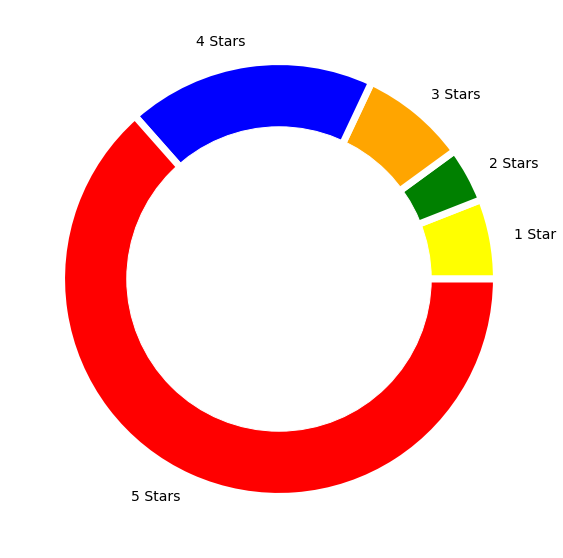

In [ ]:
#Quickly checking the distribution of review score to establish baselines
import matplotlib.pyplot as plt 
import seaborn as sns 
#Group dataframe by rating 
ratings_distribution = data[['asin','overall']] \
.groupby('overall') \
.count() \
.reset_index() \
.rename( columns = {'asin':'count'} )
#visualize distributions using a doughnut plot 
f,ax = plt.subplots( figsize = (10,10) )
names =  [ '1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars' ]
size = list( ratings_distribution['count'] )
my_circle = plt.Circle( (0,0), 0.7, color = 'white' )
plt.pie( size, labels = names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=['yellow','green','orange','blue', 'red'],
       textprops={'fontsize': 14})
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Modelling
#### Baselines
Before we get into any kind of modelling it is important that we establish some baselines to compare our model to. I'm going to use two baseline models to show that my C-LSTM has value to add that surpasses the baselines in this sentiment classification task. 


*   Base Line 1: Model that always predict the majority class. Accuracy=63.49%
*   Base Line 2: My simple Naive Bayes Model that uses bi-grams with tf-idf embeddings. Accuracy=67.30%

#### Keras Preprocessing 
Our model requires each input, for  us that's each review to be of the same length and we also plan on fine tuning the embeddings while we are training our model as done in the Zhou et al. research paper. Hence we're going to use the Keras tokenizer to map each word in our vocabulary (after putting a cap on the number of words based on the frequency of each word as put out by our word2vec model) to a unique index and then we'll use maxlen to make every review the same length by either padding from the front or truncating from the front based on the legth of each review. So the shape of our dataset would be (number of reviews, 100)
##### Embedding Matrix 
Once every word is assigned a unique index , we can create an embeddig matrix for every word in our truncated vocabulary. Every row in the matrix would be a unique word as determined by it's index from our tokenizer and it's columns would be the 300 features as output by our word2vec model so it's shape would be (number of words, 300). This embedding matrix will then become the first layer in our C-LSTM and it's embedding values will be updated using back propogation during training just like all the other parameters in the model.



#### Toekinizing and Padding

In [14]:
%%time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#Using the keras tokenizer to convert each word/phrase to a unique index
reviews_streaming_obj = LineSentence('/content/drive/Shared drives/project_reboot/reviews_phrases2.txt')
tokenizer = Tokenizer(num_words = 103771)
tokenizer.fit_on_texts(reviews_streaming_obj)
sequences = tokenizer.texts_to_sequences(reviews_streaming_obj)
#Padding and Truncating observations to get them to the same size so they can be fed 
#to our model which has an LSTM component since it requires inputs to be the same size
sequences = pad_sequences(sequences, maxlen = 100, padding = 'pre', truncating = 'pre')

CPU times: user 2min 22s, sys: 1.62 s, total: 2min 23s
Wall time: 2min 24s


In [19]:
#How each observation looks after being tokenized with keras
#Each word in each review is represented by a unique index
#The zeros are the paddings for the sentences that were shorter
#than maxlen = 100
print('Shape of our data after tokeninizing and padding: {}\n'.format(sequences.shape))
print('Data:\n')
sequences

Shape of our data after tokeninizing and padding: (1046025, 100)

Data:



array([[  249,     1, 19150, ...,    40,  2444,   295],
       [    0,     0,     0, ...,    45,    54, 97310],
       [    0,     0,     0, ...,    64,  1463,   516],
       ...,
       [    0,     0,     0, ...,     1,  1043,    58],
       [    0,     0,     0, ...,    23,   146, 14283],
       [    0,     0,     0, ...,    11, 80446, 26663]], dtype=int32)

#### Embedding Matrix

In [1]:
import numpy as np
#Creating an embedding matrix using the word2vec embeddings 
#and later we'll fine tune them by adding the matrix as an 
#embedding layer in our model
def create_embedding_lookup(model):
    embedding_lookup = {}
    for word in model.wv.vocab.keys():
        embedding_lookup[word] = model.wv[word]
    return embedding_lookup

def create_embedding_matrix(tokenizer_obj, embedding_lookup, num_words = 103771):
    embedding_matrix = np.zeros((num_words,300))
    for word, i in tokenizer_obj.word_index.items():
        if i >= num_words:
            break
        embedding_vector = embedding_lookup.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix    

In [17]:
%%time 
embedding_matrix = create_embedding_matrix( tokenizer,
                                           create_embedding_lookup(w2v_model) ) 

CPU times: user 352 ms, sys: 94.9 ms, total: 447 ms
Wall time: 450 ms


In [21]:
print("Shape of Embedding Matrix: {}\n".format(embedding_matrix.shape))
print("Embedding Matrix\n")
embedding_matrix

Shape of Embedding Matrix: (103771, 300)

Embedding Matrix



array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04923916, -0.02960364, -0.04654313, ...,  0.08607096,
        -0.06658344, -0.03600369],
       [ 0.11081685,  0.02431645, -0.01121885, ..., -0.02367711,
        -0.07412444, -0.11573192],
       ...,
       [-0.02555856,  0.06159121, -0.01665044, ...,  0.04409704,
        -0.00111578,  0.01901171],
       [ 0.07118265, -0.01440032, -0.00929476, ...,  0.08228488,
        -0.10032626,  0.0761658 ],
       [-0.00830507,  0.00577912,  0.04912167, ...,  0.0137641 ,
        -0.00216097, -0.00191563]])

#### One Hot Encoding Labels & Splitting Data into Train and Validation Sets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential 
from keras.layers import Embedding, Dropout, Conv1D, LSTM, Dense
from keras.regularizers import l2
from keras.models import load_model
import matplotlib.pyplot as plt
from itertools import cycle

In [ ]:
X = sequences
data = pd.read_csv('/content/drive/Shared drives/project_reboot/amazon_movies_and_tv_reviewsM.csv')
y = data.dropna().drop([580670,875199])[['overall']].values
one_hot_encoder = OneHotEncoder(categories='auto',sparse=False)
y = one_hot_encoder.fit_transform(y)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.05,random_state=21)
del data

In [24]:
#Sanity check
print("X Train Shape: {}\n".format(X_train.shape))
X_train

X Train Shape: (993723, 100)



array([[    0,     0,     0, ..., 10087,    12,    86],
       [ 2062,    28,     4, ...,   209,    41,  7135],
       [    0,     0,     0, ...,    38, 99987, 52023],
       ...,
       [    0,     0,     0, ...,     9,     3, 50356],
       [    0,     0,     0, ...,    27,   336,  8674],
       [  247,   487,    44, ...,     1,    60,  1263]], dtype=int32)

In [25]:
#Sanity check
print("y Train Shape: {}\n".format(y_train.shape))
y_train

y Train Shape: (993723, 5)



array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [26]:
#Sanity check
print("X Validation Shape: {}\n".format(X_val.shape))
X_val

X Validation Shape: (52302, 100)



array([[    0,     0,     0, ...,   113,    14,    24],
       [    0,     0,     0, ...,    60,    12,   804],
       [    0,     0,     0, ...,  1180,   379,   132],
       ...,
       [    0,     0,     0, ...,   149,     3,  5525],
       [    1,    78,   356, ..., 22479,    40,  8791],
       [    0,     0,     0, ..., 51830,  4726,   321]], dtype=int32)

In [27]:
#Sanity check
print("y Validation Shape: {}\n".format(y_val.shape))
y_val

y Validation Shape: (52302, 5)



array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

## Model Architecture
The model architecture I have used is exactly as described in "A C-LSTM Neural Network for Text Classification", by Xu et al. 2015
#### Layer 1: Embedding Layer
 * The embedding layer acts as a lookup for the 300 dimensional embeddings for each word in every input document as output by the Word2Vec model we trained above. These embeddings are further fine-tuned during the training of the model through back propogation just like every other parameter in the model.
 
#### Layer 2: 1D Convolution Layer
 * The 1D convolution layer has size 3 and stride 1, so as it convolves over the words in a document it essentially captures feature maps from tri-grams in every input document. It has 150 filters and uses Relu activation with a bias term. 
 * Dropped out with 50% probability
 
#### Layer 3: LSTM Layer
* The feature maps from every window of size 3 (tri-grams) from the document are then used as input to it's approproate LSTM Unit. We're using 150 nodes per LSTM unit. The output of this layer is the hidden unit of the last LSTM unit which is regarded as the document representation of the input by the authors.
* Dropped out with 50% probability

#### Layer 4: Softmax Layer
* The output of the last LSTM unit is then used as input to the last softmax layer since we're dealing with a multi-class classification problem, with 5 classes. 
* L2 Regualrized with parameter = 0.001

<br>

<img src="c_lstm_architecture.jpg">

In [36]:
c_lstm = Sequential()
c_lstm.add(Embedding(103771,300,weights=[embedding_matrix],input_length=100,trainable=True))
c_lstm.add(Conv1D(filters=150,kernel_size=3,activation='relu',use_bias=True))
c_lstm.add(Dropout(rate=0.5))
c_lstm.add(LSTM(150,return_sequences=False,return_state=False))
c_lstm.add(Dropout(rate=0.5))
c_lstm.add(Dense(5,activation='softmax',kernel_regularizer=l2(0.001)))
c_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          31131300  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 98, 150)           135150    
_________________________________________________________________
dropout_11 (Dropout)         (None, 98, 150)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_12 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 755       
Total params: 31,447,805
Trainable params: 31,447,805
Non-trainable params: 0
__________________________________________

#### Compiling and Training the Model

In [ ]:
c_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
%%time
c_lstm.fit(X_train, y_train,
          batch_size=64, epochs=2, shuffle=False,
          validation_data=(X_val, y_val))

Train on 993723 samples, validate on 52302 samples
Epoch 1/2
993723/993723 [==============================] - 2371s 2ms/step - loss: 0.7341 - acc: 0.7131 - val_loss: 0.6917 - val_acc: 0.7274
Epoch 2/2
993723/993723 [==============================] - 2356s 2ms/step - loss: 0.6710 - acc: 0.7357 - val_loss: 0.6957 - val_acc: 0.7266
CPU times: user 1h 41min 59s, sys: 8min 2s, total: 1h 50min 1s
Wall time: 1h 18min 47s


#### Observation
Our best score on validation is 72.74% on validation data which is almost 10% better than our baseline model 1 that always predicts the majority class and almost 6% better than my simpler Naive Bayes model with bi-grams tf-idf embeddings which we used as a second baseline model! Our model has more value to add to this problem.

In [ ]:
#Saving the model
c_lstm.save('/content/drive/Shared drives/project_reboot/c_lstm.h5')

#### Mutli Class ROC Curve

In [ ]:
#Load the model from the checkpoint
c_lstm = load_model('/content/drive/Shared drives/project_reboot/c_lstm.h5')

In [ ]:
%%time
y_pred = c_lstm.predict_classes(X_val)
y_pred = one_hot_encoder.fit_transform(y_pred.reshape(-1,1))

CPU times: user 1min 58s, sys: 10.5 s, total: 2min 9s
Wall time: 1min 29s


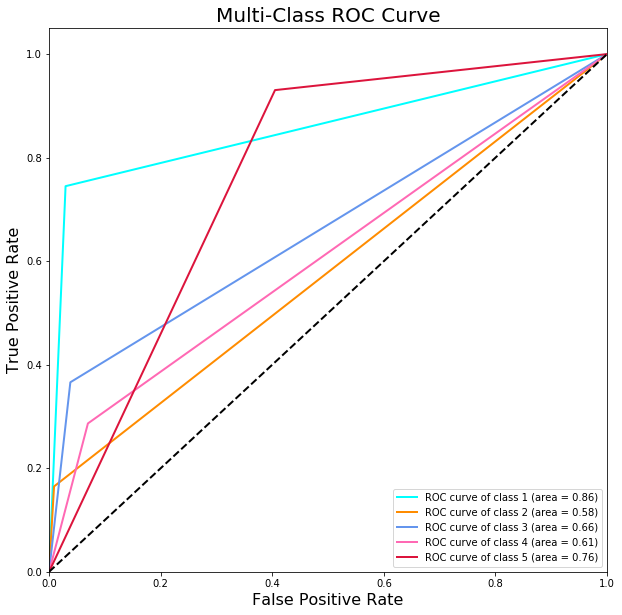

In [ ]:
# Compute ROC curve and ROC area for each class
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','hotpink','crimson'])
f,ax = plt.subplots( figsize = (10,10) )
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title('Multi-Class ROC Curve',fontsize=20)
plt.legend(loc="lower right")
plt.show()

#### Obervation
It's surprising that our model can separate 1 star reviews from other review well even with very low training examples. As expected it is also good at separating 5 star reviews from other reviews. The model struggles with distinguishing 2,3,4 star reviews from other reviews, as they seem to be a little neutral and even very subjective in most cases. Not as polarized as 1 star and 5-star reviews. The authors of the paper , also achieved state of the art results afte converting this probelm to binary with postive and negative labels. I'll go ahead and reduce the labels but I'll keep the problem multi class with labels - postive , negative and neutral. I am interested to see if the model is having trouble separating 2,3,4 reviews between each other or it's not as good with separating more neutral comments from polarized comments.

### Reducing classes and going again to see what kind of results we get

#### Baseline
 * Model that always predicts the majoirty class. Accuracy = 82%

In [ ]:
import pandas as pd 
import numpy as np
data = pd.read_csv('/content/drive/Shared drives/project_reboot/amazon_movies_and_tv_reviewsM.csv')
def reduce_classes(score):
    if score == 1 or score == 2:
        return 1
    elif score == 3:
        return 2
    else:
        return 3
data['reduced_overall'] = data['overall'].apply(reduce_classes)

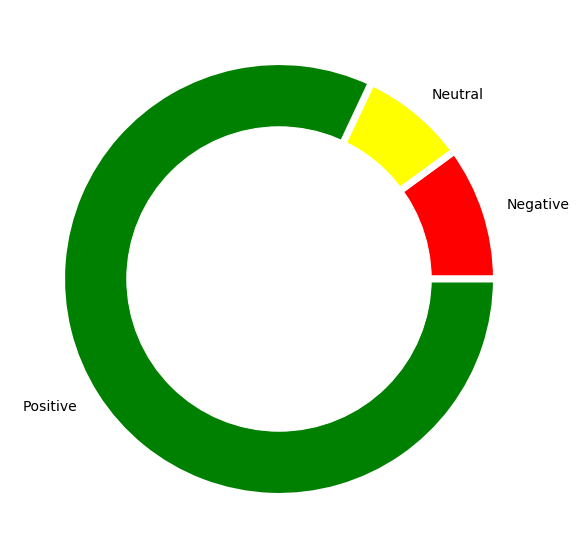

In [29]:
import matplotlib.pyplot as plt 
import seaborn as sns 
#Group dataframe by rating 
ratings_distribution = data[['asin','reduced_overall']] \
.groupby('reduced_overall') \
.count() \
.reset_index() \
.rename( columns = {'asin':'count'} )
#visualize distributions using a doughnut plot 
f,ax = plt.subplots( figsize = (10,10) )
names =  [ 'Negative', 'Neutral', 'Positive' ]
size = list( ratings_distribution['count'] )
my_circle = plt.Circle( (0,0), 0.7, color = 'white' )
plt.pie( size, labels = names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=['red','yellow','green'],
       textprops={'fontsize': 14})
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#### Splitting the data into training and validation

In [ ]:
y = data.dropna().drop([580670,875199])[['reduced_overall']].values
one_hot_encoder = OneHotEncoder(categories='auto',sparse=False)
y = one_hot_encoder.fit_transform(y)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.05,random_state=21)
del data

In [37]:
c_lstm_reduced = Sequential()
c_lstm_reduced.add(Embedding(103771,300,weights=[embedding_matrix],input_length=100,trainable=True))
c_lstm_reduced.add(Conv1D(filters=150,kernel_size=3,activation='relu',use_bias=True))
c_lstm_reduced.add(Dropout(rate=0.5))
c_lstm_reduced.add(LSTM(150,return_sequences=False,return_state=False))
c_lstm_reduced.add(Dropout(rate=0.5))
c_lstm_reduced.add(Dense(3,activation='softmax',kernel_regularizer=l2(0.001)))
c_lstm_reduced.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          31131300  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 98, 150)           135150    
_________________________________________________________________
dropout_13 (Dropout)         (None, 98, 150)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_14 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 453       
Total params: 31,447,503
Trainable params: 31,447,503
Non-trainable params: 0
__________________________________________

#### Compiling and Fitting the Model

In [ ]:
c_lstm_reduced.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [41]:
%%time
c_lstm_reduced.fit(X_train, y_train,
          batch_size=64, epochs=2, shuffle=False,
          validation_data=(X_val, y_val))

Train on 993723 samples, validate on 52302 samples
Epoch 1/2
993723/993723 [==============================] - 2410s 2ms/step - loss: 0.3191 - acc: 0.8849 - val_loss: 0.2932 - val_acc: 0.8924
Epoch 2/2
993723/993723 [==============================] - 2396s 2ms/step - loss: 0.2752 - acc: 0.8995 - val_loss: 0.2932 - val_acc: 0.8927
CPU times: user 1h 43min 49s, sys: 7min 51s, total: 1h 51min 41s
Wall time: 1h 20min 6s


We were able to achieve almost 90% accuracy on our validation data on this problem, which is 7% better than our baseline model.

In [ ]:
c_lstm_reduced.save('/content/drive/Shared drives/project_reboot/c_lstm_reduced.h5')

#### Mutli-Class ROC

In [44]:
%%time
y_pred = c_lstm_reduced.predict_classes(X_val)
y_pred = one_hot_encoder.fit_transform(y_pred.reshape(-1,1))

CPU times: user 1min 57s, sys: 11.1 s, total: 2min 9s
Wall time: 1min 22s


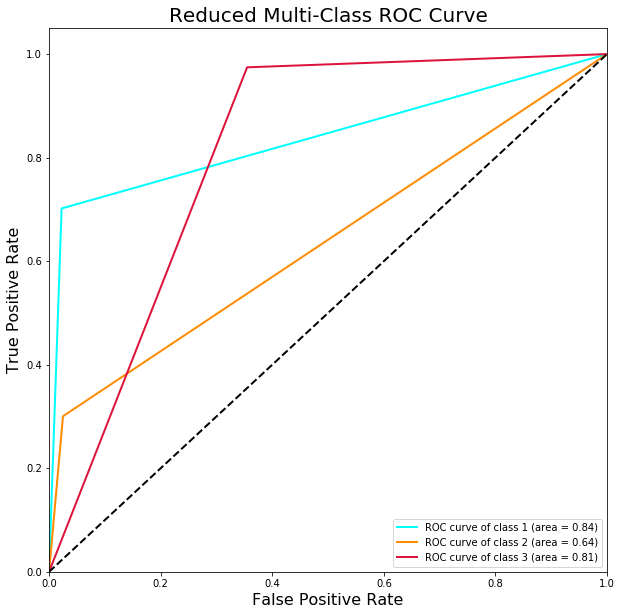

In [45]:
# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['aqua', 'darkorange', 'crimson'])
f,ax = plt.subplots( figsize = (10,10) )
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title('Reduced Multi-Class ROC Curve',fontsize=20)
plt.legend(loc="lower right")
plt.show()

#### Observation 
Our model is much better at accurately separating Postive and Negative reviews than it is at separating more subjective Neutral reviews.

#### References 
https://arxiv.org/pdf/1511.08630.pdf
<br>
http://web2.cs.columbia.edu/~blei/seminar/2016_discrete_data/readings/MikolovSutskeverChenCorradoDean2013.pdf


